## This is the first notebook done after the hackathon
### I'm using a different approach to calculating features (more array and vector based and less row and loop based) which is speeding up the calculation. 
### The thought process is the same
#### - Justin

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
welly.__version__

'0.3.4'

In [2]:
%%timeit
import os
env = %env


118 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
from IPython.display import display

In [4]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

## We're going to load a pickle file of a previously created dataframe

### The dataframe merges:
1. picks_dic = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
2. picks = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
3. wells = pd.read_csv('../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
4. gis = pd.read_csv('../../well_lat_lng.csv')

### It also excludes any wells that have nulls or zeros for Top McMurray or Base McMurray picks
This was done in notebooks: 
1. notebooks_2018/mapmaking/Map_Exploration_v2-KDtree.ipynb
2. notebooks_2018/Test_RUN_2018_02/DataCleaningPrepof_KNN_neighborPickDepth_df_creation_vA_20180210

### Let's load in the pickle file of the dataframe from previous notebook mentioned above

In [5]:
wells_df_new_cleaned_plus_nn_wNoNulls =  pd.read_pickle('wells_df_new_cleaned_plus_nn_wNoNulls.p')

In [6]:
wells_df_new_cleaned_plus_nn_wNoNulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 0 to 2192
Data columns (total 16 columns):
SitID                                  1921 non-null int64
McMurray_Base_HorID                    1921 non-null int64
McMurray_Top_HorID                     1921 non-null int64
McMurray_Base_DEPTH                    1921 non-null float64
McMurray_Top_DEPTH                     1921 non-null float64
McMurray_Base_Qual                     1921 non-null int64
McMurray_Top_Qual                      1921 non-null int64
lat                                    1921 non-null float64
lng                                    1921 non-null float64
UWI                                    1921 non-null object
Neighbors_Obj                          1921 non-null object
NN1_McMurray_Top_DEPTH                 1921 non-null float64
NN1_McMurray_Base_DEPTH                1921 non-null float64
NN1_thickness                          1921 non-null float64
MM_Top_Depth_predBy_NN1thick           1921 non-nul

In [7]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick
0  102496                14000               13000                561.0               475.0                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0        [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]                   544.0                    630.0           86.0                         475.0                                  0.0
1  102497                14000               13000                604.5               515.0                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]                   529.0                    613.0           84.0                         520.5                                 -5.5
2  102498                14000               13000                564.0               480.0                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0      [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]                   529.0                    613.0           84.0                         480.0                                  0.0
3  102500                14000               13000                636.5               549.0                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor'

In [8]:
print(len(wells_df_new_cleaned_plus_nn_wNoNulls))

1921


In [9]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick
0  102496                14000               13000                561.0               475.0                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0        [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]                   544.0                    630.0           86.0                         475.0                                  0.0
1  102497                14000               13000                604.5               515.0                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]                   529.0                    613.0           84.0                         520.5                                 -5.5
2  102498                14000               13000                564.0               480.0                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0      [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]                   529.0                    613.0           84.0                         480.0                                  0.0
3  102500                14000               13000                636.5               549.0                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor'

In [10]:
df_new = wells_df_new_cleaned_plus_nn_wNoNulls
# df_new["UWI (AGS)"] = df_new["UWI (AGS)_x"]
df_new["UWI"] = df_new["UWI"]
df_new["HorID"] = df_new["McMurray_Top_HorID"]
df_new["Pick"] = df_new["McMurray_Top_DEPTH"]
df_new["Quality"] = df_new["McMurray_Top_Qual"]
df_new["HorID_paleoz"] = df_new["McMurray_Base_HorID"]
df_new["Pick_paleoz"] = df_new["McMurray_Base_DEPTH"]
df_new["Quality_paleoz"] = df_new["McMurray_Base_Qual"]
df_new = df_new[["SitID","UWI","HorID","Pick","Quality","HorID_paleoz","Pick_paleoz","Quality_paleoz",'lat','lng','MM_Top_Depth_predBy_NN1thick','NN1_thickness']]
df_new

SitID                  UWI  HorID    Pick  Quality  HorID_paleoz  Pick_paleoz  Quality_paleoz        lat         lng  MM_Top_Depth_predBy_NN1thick  NN1_thickness
0     102496  00/12-08-067-01W4/0  13000  475.00        3         14000       561.00               1  54.785907 -110.129320                        475.00          86.00
1     102497  00/07-08-067-02W4/0  13000  515.00        3         14000       604.50               1  54.782284 -110.269446                        520.50          84.00
2     102498  00/09-11-067-02W4/0  13000  480.00        3         14000       564.00               1  54.785892 -110.186851                        480.00          84.00
3     102500  00/10-29-067-02W4/0  13000  549.00        3         14000       636.50               1  54.829624 -110.269422                        552.50          84.00
4     102501  00/06-34-067-02W4/0  13000  529.00        2         14000       613.00               1  54.840471 -110.224832                        524.00          89.00
5     102503  00/11-04-067-03W4/0  13000  488.50        2         14000       553.50               1  54.771449 -110.402983                        489.00          64.50
6     102505  00/10-08-067-03W4/0  13000  501.50        2         14000       572.50               1  54.785901 -110.422131                        508.00          64.50
7     102507  00/10-14-067-03W4/0  13000  553.50        2         14000       606.50               1  54.800533 -110.345762                        542.00          64.50
8     102514  00/10-28-067-03W4/0  13000  493.50        3         14000       558.00               1  54.829633 -110.396621                        487.00          71.00
9     102517  00/07-36-067-03W4/0  13000  536.50        2         14000       615.00               1  54.840441 -110.320301                        562.00          53.00
10    102518  00/10-02-067-04W4/0  13000  528.00        1         14000       588.50               1  54.771451 -110.498414                        517.50          71.00
11    102565  00/10-07-067-04W4/0  13000  514.00        1         14000       568.50               1  54.785896 -110.599928                        507.50          61.00
12    102577  00/11-24-067-04W4/0  13000  487.50        1         14000       552.00               1  54.814989 -110.479147                        486.00          66.00
13    102581  00/07-33-067-04W4/0  13000  509.00        1         14000       570.00               1  54.840482 -110.549109                        504.00          66.00
14    102583  00/13-03-067-05W4/0  13000  487.00        2         14000       543.50               1  54.775090 -110.688675                        491.00          52.50
15    102589  00/06-16-067-05W4/0  13000  486.00        1         14000       540.00               1  54.796954 -110.707896                        487.50          52.50
16    102592  00/07-25-067-05W4/0  13000  490.50        1         14000       557.50               1  54.826012 -110.625318                        503.00          54.50
17    102596  00/10-33-067-05W4/0  13000  481.00        1         14000       533.50               1  54.844116 -110.701599                        473.00          60.50
18    102597  00/15-01-067-06W4/0  13000  503.00        2         14000       531.50               1  54.775087 -110.777910                        477.50          54.00
19    102606  00/06-17-067-06W4/0  13000  492.00        3         14000       533.00               1  54.796947 -110.885862                        482.00          51.00
20    141727  00/07-23-067-06W4/0  13000  484.00        2         14000       534.50               1  54.811402 -110.803309                        479.00          55.50
21    102609  00/02-29-067-06W4/0  13000  493.00        2         14000       543.00               1  54.822471 -110.879581                        495.00          48.00
22    102610  00/11-05-067-07W4/0  13000  473.00        1         14000       537.00               1  54.771468 -111.038

In [11]:
print(len(df_new))

1921


In [12]:
#### Number of unique wells based on UWI
len(df_new.UWI.unique())

1921

In [13]:
df_new_test = df_new[['UWI']]

In [14]:
print(any(df_new_test.UWI == '00/11-04-067-03W4/0'))

True


## Brainstorm 1 : various features to extract
1. Find average values of [each curve] in [different] length windows [above, around, below] a depth
2. Find average for [different number of] [max, min] values in [different] length windows [above, around, below] a depth for [each curve]
3. Find gradient within [window length] around a depth point 
4. Find [min, avg, max] gradient of various [smaller window length] within a larger [larger window length]
5. Find number of gradient changes (negative to positive) of various [smaller window length] within a larger [larger window length]
6. Find difference between two windows on either side of a given depth. For each window, average for [different number of] [max, min] values in [different] length windows above & below a given depth for [each curve].

In [15]:
####
def addColWindowMean(df,col,windowSize,centered):
    featureName = col+"_mean_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).mean() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [16]:
####
def addColWindowMax(df,col,windowSize,centered):
    featureName = col+"_max_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).max() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [17]:
#### Returns a column with the min values of a window centered 
def addColWindowMin(df,col,windowSize,centered):
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).min() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
        #### unreverse
        
        df = df.sort_index(ascending=True)
    return df

In [18]:
#### helper function that takes in array and an integer for the number of highest values to find the mean of 
#### example: for an array = [1,3,6,44,33,22,452] and nValues = 2, the answer would be 44+452 / 2
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [19]:
#### Returns a column with the average of the N largest values of a window 
def addColWindowAvgMaxNvalues(df,col,windowSize,centered,nValues):
    #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
    #return df
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered+"_n"+str(nValues)
    if(centered == "around"):
        #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
        df[featureName] = df[col].rolling(center=True,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        #   # df['new_column'] = df.apply(lambda x: your_function(x['High'],x['Low'],x['Close']), axis=1)
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
        #df[featureName] = df[col].rolling(center=False,window=windowSize).nlargest(nValues).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [20]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns value
def NN1_TopMcMDepth(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth'] = df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'] 
    return df


In [21]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns *absolute* value
def NN1_TopMcMDepth_Abs(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth_Abs'] = math.fabs(df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'])
    return df

In [22]:
####
winVars = {"RangeOfCurves":['GR'],
                   "RangeOfWindows":[5,11,29],
                   "RangeOfWindowsCaution":[5],
                   "RangeOfDirection":['above','below','around'],
                   "MinOrMaxRange":['min','max'],
                   "NumbPtsRange":[1,5]}

## Read in well logs from LAS files and put into Dictionary of Dataframes. As Reading-in, add features

In [23]:
def loadAndAddFeatures():
    count=0
    data_df=[]
    count_limit =100
    list_of_failed_wells = []
    ### dictionary that holds every well as key:value or "UWI":df pair
    df_w_dict ={}
    while count < count_limit:
        for file in glob.glob('../../SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
            #### NOTE: limiting wells being read-in to 101 here !!!!!!!!!!!!!!!!
            count+=1
            if count > count_limit:
                print("hit limit of count below file for loop")
                answer = [df_w_dict,list_of_failed_wells]
                return answer
            else:
                l_df = lasio.read(file).df()
                #print(l_df)
                str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
                #l_df.DEPT = l_df.DEPT.astype(float)
                ##bottom_well_depth = l_df['DEPT'].max()
                if any(df_new.UWI == str_uwi):
                    if df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0] > -1:
                        l_df = l_df.reset_index()
                        print("got to UWI apppend")
                        l_df['UWI'] = str_uwi
                        print("UWI added is ",str_uwi," and type is ",type(str_uwi))
                        l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
#                         l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
                        l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
                        l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
                        l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]
                        #### adding in paleozoic surface pick
                        l_df['Pick_paleoz']=df_new[df_new['UWI']==str_uwi]['Pick_paleoz'].iloc[0] 
                        l_df['HorID_paleoz']=df_new[df_new['UWI']==str_uwi]['HorID_paleoz'].iloc[0]
                        l_df['Quality_paleoz']=df_new[df_new['UWI']==str_uwi]['Quality_paleoz'].iloc[0]
                        
                        #### new as of 2018-02
                        l_df['MM_Top_Depth_predBy_NN1thick']=df_new[df_new['UWI']==str_uwi]['MM_Top_Depth_predBy_NN1thick'].iloc[0]
                        l_df['NN1_thickness']=df_new[df_new['UWI']==str_uwi]['NN1_thickness'].iloc[0]

                        print("got to end of col append & pick is ",l_df.Pick.unique()[0])  
                        try:
                            print("in first try statement, count = ",count)
                            float(l_df.Pick.unique()[0])
                            l_df.Pick = l_df.Pick.astype(float)
                            l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick']=l_df['Pick']-l_df['DEPT']
#                             l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
                            l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 10 if x==0 else ( 5 if (-5 < x and x <5) else 0))
#                             lambda x: x*10 if x<2 else (x**2 if x<4 else x+10)
                            #### doing the same as below but for BASE mcMurray or Paleozoic surface pick
                            float(l_df.Pick_paleoz.unique()[0])
                            l_df.Pick_paleoz = l_df.Pick_paleoz.astype(float)
                            #l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick_paleoz']=l_df['Pick_paleoz']-l_df['DEPT']
                            l_df['new_pick2_paleoz']=l_df['new_pick_paleoz'].apply(lambda x: 1 if(x==0) else 0)
                            
                            #### new as of 2018-02
                            try:
                                l_df_new = NN1_TopMcMDepth(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            try:
                                l_df_new = NN1_TopMcMDepth_Abs(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            
                            print("got to below astype part")
                            #### instead of concat into a single dataframe, run functions & then add to dictionary   
                            ##### run functions to create features on array basis for each well in separate dataframe
                            ##### this makes certain things easier, compared to everything in a single dataframe, like making sure you don't accidentally grab data from next well up
                            ##### and will make it easier to write data back to LAS if we run into memory limitations later
                            curves = ['GR','ILD']
                            windows = [5,7,11,21]
                            directions = ["around","below","above"]
                            comboArg_A = [curves,windows,directions]
                            all_comboArgs_A = list(itertools.product(*comboArg_A))
                            for eachArgList in all_comboArgs_A:
                                try:
                                    l_df_new = addColWindowMean(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMax(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMin(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowAvgMaxNvalues(l_df,eachArgList[0],eachArgList[1],eachArgList[2],3)
                                except:
                                    pass
                            #### add resultant dataframe to dictionary
                            if l_df['DEPT'].max() < 600:
                                df_w_dict[l_df_new['UWI'][0]]= l_df_new
                        except ValueError as e:
                            print("e = ",e)
                            print ('Error picking')
                            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                            message = template.format(type(e).__name__, e.args)
                            print("message = ",message)
                            print("file = ",file)
                            print("Got except, UWI added is ",str_uwi," and type is ",type(str_uwi))
                            list_of_failed_wells.append(str_uwi)
                            #continue;
                    else:
                        pass
                else:
                    pass
            #print("result = ",df_w_dict)
    #else: 
    #    return df_w_dict, list_of_failed_wells
    answer = [df_w_dict,list_of_failed_wells]
    
    return answer

In [24]:
## %timeit
answer = loadAndAddFeatures()

got to UWI apppend
UWI added is  00/01-01-073-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  607.0
in first try statement, count =  1
got to below astype part
got to UWI apppend
UWI added is  00/01-03-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  243.0
in first try statement, count =  3
got to below astype part
got to UWI apppend
UWI added is  00/01-04-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  631.0
in first try statement, count =  4
got to below astype part
got to UWI apppend
UWI added is  00/01-05-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  253.0
in first try statement, count =  5
got to below astype part
got to UWI apppend
UWI added is  00/01-08-080-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  411.0
in first try statement, count =  6
got to below astype part
got to UWI apppend
UWI added is  00/01-09-080-13W4/0  and type is  <class 'str'>
got 

got to end of col append & pick is  531.0
in first try statement, count =  53
got to below astype part
got to UWI apppend
UWI added is  00/03-07-071-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  473.0
in first try statement, count =  55
got to below astype part
got to UWI apppend
UWI added is  00/03-09-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  596.5
in first try statement, count =  56
got to below astype part
got to UWI apppend
UWI added is  00/03-10-088-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  149.96
in first try statement, count =  57
got to below astype part
got to UWI apppend
UWI added is  00/03-11-080-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  355.5
in first try statement, count =  58
got to below astype part
got to UWI apppend
UWI added is  00/03-12-077-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  323.5
in first try statement, count =  59
g

got to below astype part
got to UWI apppend
UWI added is  00/04-29-076-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  843.0
in first try statement, count =  113
got to below astype part
got to UWI apppend
UWI added is  00/04-30-078-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  451.5
in first try statement, count =  114
got to below astype part
got to UWI apppend
UWI added is  00/04-30-078-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  475.0
in first try statement, count =  115
got to below astype part
got to UWI apppend
UWI added is  00/04-30-083-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  291.0
in first try statement, count =  116
got to below astype part
got to UWI apppend
UWI added is  00/04-30-084-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  256.0
in first try statement, count =  117
got to below astype part
got to UWI apppend
UWI added is  00/04-32-085-23W4

UWI added is  00/05-25-081-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  453.0
in first try statement, count =  165
got to below astype part
got to UWI apppend
UWI added is  00/05-26-090-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  209.0
in first try statement, count =  167
got to below astype part
got to UWI apppend
UWI added is  00/05-27-068-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  469.0
in first try statement, count =  168
got to below astype part
got to UWI apppend
UWI added is  00/05-29-068-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  455.5
in first try statement, count =  169
got to below astype part
got to UWI apppend
UWI added is  00/05-29-078-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  374.0
in first try statement, count =  170
got to below astype part
got to UWI apppend
UWI added is  00/05-31-074-11W4/0  and type is  <class 'str'>
got to end of

UWI added is  00/06-06-080-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  431.0
in first try statement, count =  218
got to below astype part
got to UWI apppend
UWI added is  00/06-06-082-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  339.55
in first try statement, count =  219
got to below astype part
got to UWI apppend
UWI added is  00/06-06-082-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  314.55
in first try statement, count =  220
got to below astype part
got to UWI apppend
UWI added is  00/06-06-084-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  274.0
in first try statement, count =  221
got to below astype part
got to UWI apppend
UWI added is  00/06-07-069-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  531.0
in first try statement, count =  222
got to below astype part
got to UWI apppend
UWI added is  00/06-07-070-11W4/0  and type is  <class 'str'>
got to end 

UWI added is  00/06-12-088-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  239.0
in first try statement, count =  269
got to below astype part
got to UWI apppend
UWI added is  00/06-13-067-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  493.0
in first try statement, count =  270
got to below astype part
got to UWI apppend
UWI added is  00/06-13-067-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  494.0
in first try statement, count =  271
got to below astype part
got to UWI apppend
UWI added is  00/06-13-067-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  488.0
in first try statement, count =  272
got to below astype part
got to UWI apppend
UWI added is  00/06-13-068-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  546.0
in first try statement, count =  273
got to below astype part
got to UWI apppend
UWI added is  00/06-13-073-06W4/0  and type is  <class 'str'>
got to end of

UWI added is  00/06-21-071-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  601.07
in first try statement, count =  318
got to below astype part
got to UWI apppend
UWI added is  00/06-21-073-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  591.92
in first try statement, count =  319
got to below astype part
got to UWI apppend
UWI added is  00/06-21-075-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  642.52
in first try statement, count =  320
got to below astype part
got to UWI apppend
UWI added is  00/06-21-077-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  572.11
in first try statement, count =  321
got to below astype part
got to UWI apppend
UWI added is  00/06-21-082-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  209.0
in first try statement, count =  322
got to below astype part
got to UWI apppend
UWI added is  00/06-22-069-05W4/0  and type is  <class 'str'>
got to en

UWI added is  00/06-26-075-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  576.07
in first try statement, count =  366
got to below astype part
got to UWI apppend
UWI added is  00/06-26-078-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  374.0
in first try statement, count =  367
got to below astype part
got to UWI apppend
UWI added is  00/06-26-082-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  365.76
in first try statement, count =  368
got to below astype part
got to UWI apppend
UWI added is  00/06-27-067-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  518.0
in first try statement, count =  370
got to below astype part
got to UWI apppend
UWI added is  00/06-27-068-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  486.16
in first try statement, count =  371
got to below astype part
got to UWI apppend
UWI added is  00/06-27-071-08W4/0  and type is  <class 'str'>
got to end

UWI added is  00/06-33-070-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  448.0
in first try statement, count =  418
got to below astype part
got to UWI apppend
UWI added is  00/06-33-070-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  580.03
in first try statement, count =  420
got to below astype part
got to UWI apppend
UWI added is  00/06-33-074-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  546.81
in first try statement, count =  421
got to below astype part
got to UWI apppend
UWI added is  00/06-33-074-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  760.78
in first try statement, count =  422
got to below astype part
got to UWI apppend
UWI added is  00/06-33-076-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  772.97
in first try statement, count =  423
got to below astype part
got to UWI apppend
UWI added is  00/06-33-078-18W4/0  and type is  <class 'str'>
got to en

UWI added is  00/07-01-079-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  476.1
in first try statement, count =  468
got to below astype part
got to UWI apppend
UWI added is  00/07-01-080-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  205.0
in first try statement, count =  469
got to below astype part
got to UWI apppend
UWI added is  00/07-01-084-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  332.84
in first try statement, count =  470
got to below astype part
got to UWI apppend
UWI added is  00/07-01-084-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  388.92
in first try statement, count =  471
got to below astype part
got to UWI apppend
UWI added is  00/07-02-067-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  493.0
in first try statement, count =  473
got to below astype part
got to UWI apppend
UWI added is  00/07-02-075-24W4/0  and type is  <class 'str'>
got to end 

UWI added is  00/07-10-070-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  669.34
in first try statement, count =  522
got to below astype part
got to UWI apppend
UWI added is  00/07-10-072-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  513.28
in first try statement, count =  523
got to below astype part
got to UWI apppend
UWI added is  00/07-10-073-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  461.0
in first try statement, count =  524
got to below astype part
got to UWI apppend
UWI added is  00/07-10-075-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  450.0
in first try statement, count =  525
got to below astype part
got to UWI apppend
UWI added is  00/07-10-078-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  589.79
in first try statement, count =  526
got to below astype part
got to UWI apppend
UWI added is  00/07-11-073-12W4/0  and type is  <class 'str'>
got to end

UWI added is  00/07-16-079-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  429.77
in first try statement, count =  571
got to below astype part
got to UWI apppend
UWI added is  00/07-16-083-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  431.0
in first try statement, count =  572
got to below astype part
got to UWI apppend
UWI added is  00/07-17-070-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  455.5
in first try statement, count =  574
got to below astype part
got to UWI apppend
UWI added is  00/07-17-075-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  435.0
in first try statement, count =  575
got to below astype part
got to UWI apppend
UWI added is  00/07-17-076-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  456.59
in first try statement, count =  576
got to below astype part
got to UWI apppend
UWI added is  00/07-17-082-10W4/0  and type is  <class 'str'>
got to end 

UWI added is  00/07-23-081-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  420.0
in first try statement, count =  620
got to below astype part
got to UWI apppend
UWI added is  00/07-23-083-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  285.29
in first try statement, count =  621
got to below astype part
got to UWI apppend
UWI added is  00/07-24-069-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  442.26
in first try statement, count =  622
got to below astype part
got to UWI apppend
UWI added is  00/07-24-071-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  445.01
in first try statement, count =  624
got to below astype part
got to UWI apppend
UWI added is  00/07-24-071-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  621.79
in first try statement, count =  625
got to below astype part
got to UWI apppend
UWI added is  00/07-24-075-13W4/0  and type is  <class 'str'>
got to en

UWI added is  00/07-30-075-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  552.0
in first try statement, count =  676
got to below astype part
got to UWI apppend
UWI added is  00/07-31-069-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  440.0
in first try statement, count =  677
got to below astype part
got to UWI apppend
UWI added is  00/07-31-069-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  437.0
in first try statement, count =  678
got to below astype part
got to UWI apppend
UWI added is  00/07-31-070-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  495.0
in first try statement, count =  679
got to below astype part
got to UWI apppend
UWI added is  00/07-31-072-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  422.0
in first try statement, count =  681
got to below astype part
got to UWI apppend
UWI added is  00/07-32-073-21W4/0  and type is  <class 'str'>
got to end of

UWI added is  00/08-01-081-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  212.0
in first try statement, count =  729
got to below astype part
got to UWI apppend
UWI added is  00/08-02-067-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  500.0
in first try statement, count =  730
got to below astype part
got to UWI apppend
UWI added is  00/08-02-080-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  437.5
in first try statement, count =  731
got to below astype part
got to UWI apppend
UWI added is  00/08-02-083-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  216.0
in first try statement, count =  732
got to below astype part
got to UWI apppend
UWI added is  00/08-04-073-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  489.0
in first try statement, count =  733
got to below astype part
got to UWI apppend
UWI added is  00/08-04-079-06W4/0  and type is  <class 'str'>
got to end of

UWI added is  00/09-11-068-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  514.0
in first try statement, count =  783
got to below astype part
got to UWI apppend
UWI added is  00/09-11-077-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  452.5
in first try statement, count =  784
got to below astype part
got to UWI apppend
UWI added is  00/09-12-070-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  477.0
in first try statement, count =  785
got to below astype part
got to UWI apppend
UWI added is  00/09-13-072-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.0
in first try statement, count =  786
got to below astype part
got to UWI apppend
UWI added is  00/09-13-083-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  232.0
in first try statement, count =  787
got to below astype part
got to UWI apppend
UWI added is  00/09-14-071-06W4/0  and type is  <class 'str'>
got to end of

UWI added is  00/10-02-074-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  411.0
in first try statement, count =  832
got to below astype part
got to UWI apppend
UWI added is  00/10-02-077-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  446.0
in first try statement, count =  833
got to below astype part
got to UWI apppend
UWI added is  00/10-02-082-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  198.73
in first try statement, count =  834
got to below astype part
got to UWI apppend
UWI added is  00/10-03-067-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  469.0
in first try statement, count =  837
got to below astype part
got to UWI apppend
UWI added is  00/10-03-068-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  457.2
in first try statement, count =  838
got to below astype part
got to UWI apppend
UWI added is  00/10-03-072-05W5/0  and type is  <class 'str'>
got to end o

UWI added is  00/10-08-074-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  365.76
in first try statement, count =  885
got to below astype part
got to UWI apppend
UWI added is  00/10-08-076-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  350.5
in first try statement, count =  886
got to below astype part
got to UWI apppend
UWI added is  00/10-08-076-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  345.03
in first try statement, count =  887
got to below astype part
got to UWI apppend
UWI added is  00/10-08-076-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  404.0
in first try statement, count =  888
got to below astype part
got to UWI apppend
UWI added is  00/10-08-082-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  301.5
in first try statement, count =  889
got to below astype part
got to UWI apppend
UWI added is  00/10-08-083-05W4/0  and type is  <class 'str'>
got to end 

UWI added is  00/10-14-077-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  392.5
in first try statement, count =  936
got to below astype part
got to UWI apppend
UWI added is  00/10-14-078-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  362.1
in first try statement, count =  937
got to below astype part
got to UWI apppend
UWI added is  00/10-14-080-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  370.03
in first try statement, count =  938
got to below astype part
got to UWI apppend
UWI added is  00/10-14-081-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  306.02
in first try statement, count =  939
got to below astype part
got to UWI apppend
UWI added is  00/10-14-082-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  223.11
in first try statement, count =  940
got to below astype part
got to UWI apppend
UWI added is  00/10-15-071-07W4/0  and type is  <class 'str'>
got to end

UWI added is  00/10-19-078-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  482.8
in first try statement, count =  993
got to below astype part
got to UWI apppend
UWI added is  00/10-19-078-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  479.0
in first try statement, count =  994
got to below astype part
got to UWI apppend
UWI added is  00/10-19-083-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  269.44
in first try statement, count =  995
got to below astype part
got to UWI apppend
UWI added is  00/10-20-071-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  436.47
in first try statement, count =  998
got to below astype part
got to UWI apppend
UWI added is  00/10-20-072-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  452.32
in first try statement, count =  999
got to below astype part
got to UWI apppend
UWI added is  00/10-20-073-04W5/0  and type is  <class 'str'>
got to end

got to UWI apppend
UWI added is  00/10-25-074-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  412.7
in first try statement, count =  1046
got to below astype part
got to UWI apppend
UWI added is  00/10-25-075-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  555.0
in first try statement, count =  1047
got to below astype part
got to UWI apppend
UWI added is  00/10-25-076-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  724.81
in first try statement, count =  1048
got to below astype part
got to UWI apppend
UWI added is  00/10-25-079-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  297.0
in first try statement, count =  1049
got to below astype part
got to UWI apppend
UWI added is  00/10-25-081-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  202.69
in first try statement, count =  1050
got to below astype part
got to UWI apppend
UWI added is  00/10-25-083-19W4/0  and type is  <

got to below astype part
got to UWI apppend
UWI added is  00/10-29-069-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  432.5
in first try statement, count =  1093
got to below astype part
got to UWI apppend
UWI added is  00/10-29-072-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  484.0
in first try statement, count =  1094
got to below astype part
got to UWI apppend
UWI added is  00/10-29-073-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  438.0
in first try statement, count =  1096
got to below astype part
got to UWI apppend
UWI added is  00/10-29-075-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  460.86
in first try statement, count =  1097
got to below astype part
got to UWI apppend
UWI added is  00/10-29-077-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  293.83
in first try statement, count =  1098
got to below astype part
got to UWI apppend
UWI added is  00/10-29-0

in first try statement, count =  1138
got to below astype part
got to UWI apppend
UWI added is  00/10-33-072-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  638.86
in first try statement, count =  1139
got to below astype part
got to UWI apppend
UWI added is  00/10-33-075-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  569.98
in first try statement, count =  1140
got to below astype part
got to UWI apppend
UWI added is  00/10-33-078-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  456.0
in first try statement, count =  1141
got to below astype part
got to UWI apppend
UWI added is  00/10-33-078-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  409.0
in first try statement, count =  1142
got to below astype part
got to UWI apppend
UWI added is  00/10-33-079-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  215.8
in first try statement, count =  1143
got to below astype part
got t

got to end of col append & pick is  598.02
in first try statement, count =  1190
got to below astype part
got to UWI apppend
UWI added is  00/11-03-079-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  289.0
in first try statement, count =  1191
got to below astype part
got to UWI apppend
UWI added is  00/11-04-067-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  488.5
in first try statement, count =  1193
got to below astype part
got to UWI apppend
UWI added is  00/11-04-071-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  476.71
in first try statement, count =  1194
got to below astype part
got to UWI apppend
UWI added is  00/11-04-073-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  498.0
in first try statement, count =  1195
got to below astype part
got to UWI apppend
UWI added is  00/11-04-074-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.0
in first try statement, co

UWI added is  00/11-09-071-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  438.0
in first try statement, count =  1240
got to below astype part
got to UWI apppend
UWI added is  00/11-09-076-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  444.0
in first try statement, count =  1241
got to below astype part
got to UWI apppend
UWI added is  00/11-09-079-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  405.3
in first try statement, count =  1242
got to below astype part
got to UWI apppend
UWI added is  00/11-09-080-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  409.04
in first try statement, count =  1243
got to below astype part
got to UWI apppend
UWI added is  00/11-09-082-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  362.1
in first try statement, count =  1244
got to below astype part
got to UWI apppend
UWI added is  00/11-09-083-16W4/0  and type is  <class 'str'>
got to 

got to UWI apppend
UWI added is  00/11-15-072-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  459.0
in first try statement, count =  1295
got to below astype part
got to UWI apppend
UWI added is  00/11-15-072-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  428.24
in first try statement, count =  1296
got to below astype part
got to UWI apppend
UWI added is  00/11-15-073-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  670.56
in first try statement, count =  1297
got to below astype part
got to UWI apppend
UWI added is  00/11-15-073-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  577.6
in first try statement, count =  1298
got to below astype part
got to UWI apppend
UWI added is  00/11-15-075-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  629.11
in first try statement, count =  1299
got to below astype part
got to UWI apppend
UWI added is  00/11-15-077-11W4/0  and type is  

got to below astype part
got to UWI apppend
UWI added is  00/11-22-070-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  612.04
in first try statement, count =  1350
got to below astype part
got to UWI apppend
UWI added is  00/11-22-071-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  506.58
in first try statement, count =  1351
got to below astype part
got to UWI apppend
UWI added is  00/11-22-074-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  463.91
in first try statement, count =  1353
got to below astype part
got to UWI apppend
UWI added is  00/11-22-090-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  239.0
in first try statement, count =  1354
got to below astype part
got to UWI apppend
UWI added is  00/11-23-069-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  557.0
in first try statement, count =  1355
got to below astype part
got to UWI apppend
UWI added is  00/11-23-

in first try statement, count =  1400
got to below astype part
got to UWI apppend
UWI added is  00/11-29-068-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  470.0
in first try statement, count =  1401
got to below astype part
got to UWI apppend
UWI added is  00/11-29-071-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  423.0
in first try statement, count =  1402
got to below astype part
got to UWI apppend
UWI added is  00/11-29-071-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  514.5
in first try statement, count =  1403
got to below astype part
got to UWI apppend
UWI added is  00/11-29-074-01W4/0  and type is  <class 'str'>
got to end of col append & pick is  482.0
in first try statement, count =  1404
got to below astype part
got to UWI apppend
UWI added is  00/11-29-079-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  434.0
in first try statement, count =  1405
got to below astype part
got to 

got to end of col append & pick is  527.3
in first try statement, count =  1454
got to below astype part
got to UWI apppend
UWI added is  00/11-34-083-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  191.5
in first try statement, count =  1456
got to below astype part
got to UWI apppend
UWI added is  00/11-35-071-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  470.0
in first try statement, count =  1458
got to below astype part
got to UWI apppend
UWI added is  00/11-35-072-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  536.0
in first try statement, count =  1459
got to below astype part
got to UWI apppend
UWI added is  00/11-35-073-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  501.4
in first try statement, count =  1460
got to below astype part
got to UWI apppend
UWI added is  00/11-35-073-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  596.49
in first try statement, cou

UWI added is  00/12-20-079-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  225.0
in first try statement, count =  1504
got to below astype part
got to UWI apppend
UWI added is  00/12-21-071-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  455.0
in first try statement, count =  1505
got to below astype part
got to UWI apppend
UWI added is  00/12-22-078-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  549.0
in first try statement, count =  1506
got to below astype part
got to UWI apppend
UWI added is  00/12-23-079-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  459.0
in first try statement, count =  1507
got to below astype part
got to UWI apppend
UWI added is  00/12-23-082-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  446.0
in first try statement, count =  1508
got to below astype part
got to UWI apppend
UWI added is  00/12-26-072-05W4/0  and type is  <class 'str'>
got to e

UWI added is  00/14-14-079-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  413.0
in first try statement, count =  1562
got to below astype part
got to UWI apppend
UWI added is  00/14-15-073-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  610.0
in first try statement, count =  1563
got to below astype part
got to UWI apppend
UWI added is  00/14-15-084-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  263.0
in first try statement, count =  1564
got to below astype part
got to UWI apppend
UWI added is  00/14-16-071-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  468.0
in first try statement, count =  1565
got to below astype part
got to UWI apppend
UWI added is  00/14-17-081-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  449.0
in first try statement, count =  1566
got to below astype part
got to UWI apppend
UWI added is  00/14-18-074-12W4/0  and type is  <class 'str'>
got to e

Header section Parameter regexp=~P was not found.


got to UWI apppend
UWI added is  00/15-21-084-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  181.97
in first try statement, count =  1597
got to below astype part
got to UWI apppend
UWI added is  00/15-23-075-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  375.0
in first try statement, count =  1598
got to below astype part
got to UWI apppend
UWI added is  00/15-23-079-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  416.5
in first try statement, count =  1599
got to below astype part
got to UWI apppend
UWI added is  00/15-24-074-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  605.0
in first try statement, count =  1600
got to below astype part
got to UWI apppend
UWI added is  00/15-26-068-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  523.0
in first try statement, count =  1601
got to below astype part
got to UWI apppend
UWI added is  00/15-26-077-09W4/0  and type is  <c

got to UWI apppend
UWI added is  AA/01-05-092-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  109.0
in first try statement, count =  1653
got to below astype part
got to UWI apppend
UWI added is  AA/01-05-101-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  512.0
in first try statement, count =  1654
got to below astype part
got to UWI apppend
UWI added is  AA/01-06-098-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  5.0
in first try statement, count =  1655
got to below astype part
got to UWI apppend
UWI added is  AA/01-07-094-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  59.74
in first try statement, count =  1656
got to below astype part
got to UWI apppend
UWI added is  AA/01-08-095-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  59.44
in first try statement, count =  1657
got to below astype part
got to UWI apppend
UWI added is  AA/01-09-095-13W4/0  and type is  <clas

In [25]:
#answer=[df_w_dict,list_of_failed_wells]
df_w_dict = answer[0]
list_of_failed_wells = answer[1]

In [26]:
#### dumping dict of data frame to pickle file
wells_and_features_20180210 = df_w_dict
pickle.dump(wells_and_features_20180210, open( "dict_of_df_wells_and_features_class3_20180211.p", "wb" ) )

### NOTE: not all well logs were read-in successfully, need to go back and find out why

In [27]:
#print(df_w_dict)

In [28]:
print("list_of_failed_wells",list_of_failed_wells)

list_of_failed_wells []


In [29]:
df_w_dict['00/04-13-077-05W4/0']

DEPT     ILD   DPHI   NPHI       GR                  UWI   SitID   Pick  HorID  Quality  Pick_paleoz  HorID_paleoz  Quality_paleoz  MM_Top_Depth_predBy_NN1thick  NN1_thickness  new_pick  new_pick2  new_pick_paleoz  new_pick2_paleoz  DistFrom_NN1_TopDepth  GR_mean_5winSize_diraround  GR_max_5winSize_diraround  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_mean_5winSize_dirabove  GR_max_5winSize_dirabove  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_mean_7winSize_diraround  GR_max_7winSize_diraround  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  GR_mean_7winSize_dirabove  GR_max_7winSize_dirabove  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_mean_11winSize_diraround  GR_max_11winSize_diraround  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_mean_11winSize_dirabove  GR_max_11winSize_dirabove  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_mean_21winSize_diraround  GR_max_21winSize_diraround  \
0    165.00   2.808  0.280  0.542  104.464  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    171.00          0           245.00                 0                 162.50                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
1    165.25   2.811  0.276  0.536  105.686  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.75          0           244.75                 0                 162.25                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
2    165.50   2.922  0.273  0.533  107.521  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.50          0           244.50                 0                 162.00                    104.4846                    107.521                     99.650                    106.103000                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
3    165.75   2.979  0.271  0.530  105.102  00/

In [30]:
## testing one dataframe of one well in dictionary of all that were successfully read in
df_w_dict['00/01-03-085-15W4/0'].shape

(518, 84)

In [31]:
print(len(df_w_dict))

1109


## Turn dictionary of dataframes into single dataframe

In [32]:
def turnDictofDFtoDF(dict_of_df):
    data_df = pd.DataFrame()
    list_of_df = []
    values = dict_of_df.values()
    for each in values:
        list_of_df.append(each)
    data_df = pd.concat(list_of_df)
    return data_df
        

In [33]:
data_df = turnDictofDFtoDF(df_w_dict)
data_df.shape

(922272, 93)

In [34]:
type(data_df)

pandas.core.frame.DataFrame

In [35]:
#### dumpingdata frame to pickle file
df_wells_and_features_20180210 = data_df
pickle.dump(df_wells_and_features_20180210, open( "df_wells_and_features_class3_20180211_qual_all.p", "wb" ) )

In [36]:
paleozoic_pick_test = data_df['new_pick_paleoz'][1800:2000]
paleozoic_pick_test

561    88.25
562    88.00
563    87.75
564    87.50
565    87.25
566    87.00
567    86.75
568    86.50
569    86.25
570    86.00
571    85.75
572    85.50
573    85.25
574    85.00
575    84.75
576    84.50
577    84.25
578    84.00
579    83.75
580    83.50
581    83.25
582    83.00
583    82.75
584    82.50
585    82.25
586    82.00
587    81.75
588    81.50
589    81.25
590    81.00
591    80.75
592    80.50
593    80.25
594    80.00
595    79.75
596    79.50
597    79.25
598    79.00
599    78.75
600    78.50
601    78.25
602    78.00
603    77.75
604    77.50
605    77.25
606    77.00
607    76.75
608    76.50
609    76.25
610    76.00
611    75.75
612    75.50
613    75.25
614    75.00
615    74.75
616    74.50
617    74.25
618    74.00
619    73.75
620    73.50
621    73.25
622    73.00
623    72.75
624    72.50
625    72.25
626    72.00
627    71.75
628    71.50
629    71.25
630    71.00
631    70.75
632    70.50
633    70.25
634    70.00
635    69.75
636    69.50
637    69.25

## Key variables that hold data frame column names

In [37]:
keys = ['ILD','DPHI','GR','NPHI','CALI','COND','DELT','RHOB','PHIN','DT','ILM','SP','SFLU','IL','DEPTH','DEPH','MD']

In [38]:
keys2 = ['ILD','DPHI','GR','NPHI','CALI','RHOB']

Adding deritive features

In [39]:
all_col_names = list(df_w_dict['00/04-13-077-05W4/0'])
all_col_names

['DEPT',
 'ILD',
 'DPHI',
 'NPHI',
 'GR',
 'UWI',
 'SitID',
 'Pick',
 'HorID',
 'Quality',
 'Pick_paleoz',
 'HorID_paleoz',
 'Quality_paleoz',
 'MM_Top_Depth_predBy_NN1thick',
 'NN1_thickness',
 'new_pick',
 'new_pick2',
 'new_pick_paleoz',
 'new_pick2_paleoz',
 'DistFrom_NN1_TopDepth',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_

In [40]:
##old
OLDfeatures2 = ['DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

In [41]:
# features2original_old = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
# features2_old = [
#     #'DEPT',
#  'DPHI',
#  'NPHI',
#  'GR',
#  'ILD',
#  'SitID',
#  'new_pick_paleoz',
#  'GR_mean_5winSize_diraround',
#  'GR_max_5winSize_diraround',
#  'GR_min_5winSize_diraround',
#  'GR_min_5winSize_diraround_n3',
#  'GR_mean_5winSize_dirabove',
#  'GR_max_5winSize_dirabove',
#  'GR_min_5winSize_dirabove',
#  'GR_min_5winSize_dirabove_n3',
#  'GR_mean_7winSize_diraround',
#  'GR_max_7winSize_diraround',
#  'GR_min_7winSize_diraround',
#  'GR_min_7winSize_diraround_n3',
#  'GR_mean_7winSize_dirabove',
#  'GR_max_7winSize_dirabove',
#  'GR_min_7winSize_dirabove',
#  'GR_min_7winSize_dirabove_n3',
#  'GR_mean_11winSize_diraround',
#  'GR_max_11winSize_diraround',
#  'GR_min_11winSize_diraround',
#  'GR_min_11winSize_diraround_n3',
#  'GR_mean_11winSize_dirabove',
#  'GR_max_11winSize_dirabove',
#  'GR_min_11winSize_dirabove',
#  'GR_min_11winSize_dirabove_n3',
#  'GR_mean_21winSize_diraround',
#  'GR_max_21winSize_diraround',
#  'GR_min_21winSize_diraround',
#  'GR_min_21winSize_diraround_n3',
#  'GR_mean_21winSize_dirabove',
#  'GR_max_21winSize_dirabove',
#  'GR_min_21winSize_dirabove',
#  'GR_min_21winSize_dirabove_n3',
#  'ILD_mean_5winSize_diraround',
#  'ILD_max_5winSize_diraround',
#  'ILD_min_5winSize_diraround',
#  'ILD_min_5winSize_diraround_n3',
#  'ILD_mean_5winSize_dirabove',
#  'ILD_max_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove_n3',
#  'ILD_mean_7winSize_diraround',
#  'ILD_max_7winSize_diraround',
#  'ILD_min_7winSize_diraround',
#  'ILD_min_7winSize_diraround_n3',
#  'ILD_mean_7winSize_dirabove',
#  'ILD_max_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove_n3',
#  'ILD_mean_11winSize_diraround',
#  'ILD_max_11winSize_diraround',
#  'ILD_min_11winSize_diraround',
#  'ILD_min_11winSize_diraround_n3',
#  'ILD_mean_11winSize_dirabove',
#  'ILD_max_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove_n3',
#  'ILD_mean_21winSize_diraround',
#  'ILD_max_21winSize_diraround',
#  'ILD_min_21winSize_diraround',
#  'ILD_min_21winSize_diraround_n3',
#  'ILD_mean_21winSize_dirabove',
#  'ILD_max_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove_n3']
# label = 'new_pick2'
# train_X2 = data_df[features2]
# train_y = data_df[label]

In [42]:
# DistFrom_NN1_TopDepth_Abs
features2original = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
features2 = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']
label = 'new_pick2'
train_X2 = data_df[features2]
train_y = data_df[label]

In [43]:
train_X2.shape

(922272, 72)

In [44]:
from xgboost.sklearn import XGBRegressor
model2 = XGBRegressor()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

array([-0.00855201,  0.01895139,  0.01895139, ...,  0.06860453,
        0.06694835,  0.06694835], dtype=float32)

In [45]:
well_data=data_df.copy()

In [46]:
well_data.shape

(922272, 93)

In [47]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [48]:
features_originalB = ['CALI','DEPT','DPHI','GR','ILD','NPHI']
features = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick2_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

label = 'new_pick2'

In [49]:
seed = 123

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features]
train_y = train_df[label]
test_X = test_df[features]
test_y = test_df[label]

In [52]:
model = XGBRegressor(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

array([-0.00386989, -0.00386989, -0.00386989, ..., -0.04143202,
       -0.04143202, -0.03548914], dtype=float32)

In [53]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

CALI  COND  DELT    DEPT   DPHI  DT  DistFrom_NN1_TopDepth      GR  GR_max_11winSize_dirabove  GR_max_11winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_5winSize_dirabove  GR_max_5winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_11winSize_dirabove  GR_mean_11winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_5winSize_dirabove  GR_mean_5winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  HorID  HorID_paleoz     ILD  \
0   NaN   NaN   NaN  100.00  0.332 NaN                 162.00  89.628                        NaN                         NaN                        NaN                         NaN                       NaN                        NaN                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                         NaN                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                        NaN                           NaN                       NaN                          NaN                        NaN                           NaN  13000         14000  14.499   
1   NaN   NaN   NaN  100.25  0.338 NaN                 161.75  90.322                        NaN                         NaN                        NaN                         NaN                       NaN                        NaN                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                         NaN                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                        NaN                           NaN                       NaN                          NaN                        NaN                           NaN  13000         14000  13.976   
2   NaN   NaN   NaN  100.50  0.333 NaN                 161.50  89.781                        NaN                         NaN                        NaN                         NaN                       NaN                     92.404                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                     90.6472                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                     89.628                     91.275667                       NaN                          NaN                        NaN                           NaN  13000         14000  13.729   
3   NaN   N

In [54]:
len(test_df_pred.UWI.unique())

221

In [55]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 14.33615602344954


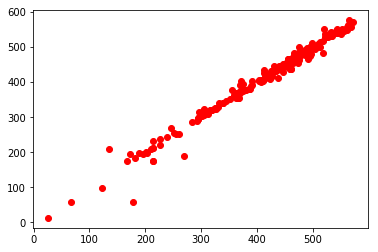

In [56]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

Text(0,0.5,'Predicted Depth')

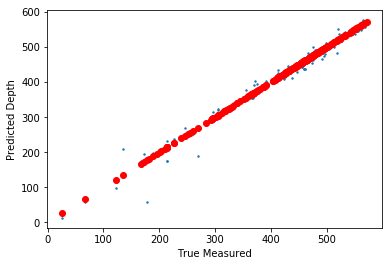

In [57]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [58]:
import pdvega
import vega

In [59]:
test_df_pred2

CALI     COND     DELT     DEPT    DPHI  DT  DistFrom_NN1_TopDepth        GR  GR_max_11winSize_dirabove  GR_max_11winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_5winSize_dirabove  GR_max_5winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_11winSize_dirabove  GR_mean_11winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_5winSize_dirabove  GR_mean_5winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  HorID  \
621      NaN      NaN      NaN  255.250  0.2640 NaN                  6.750   79.2700                   114.9960                    102.7100                   114.9960                    114.9960                   99.1050                    95.0600                  101.3890                     99.105                   99.535364                    92.700091                   91.877857                    93.877048                   90.27740                    86.02960                  92.388429                   89.734000                    79.2700                    113.523333                     78.0690                     100.487333                    67.9980                    113.523333                     73.6010                     113.523333                   79.2700                    96.177000                    78.0690                     90.936333                   79.2700                    98.585667                    78.0690                     97.683333  13000   
891      NaN      NaN      NaN  437.750  0.1430 NaN                 -2.750   53.6420                    53.6420                     80.3690                    53.6420                     88.4050                   53.6420                    60.7300                   53.6420                     67.283                   43.541818                    57.282091                   37.799238                    59.561857                   49.31800                    54.27800                  47.510429                   55.121857                    34.3250                     51.411667                     43.9910                      74.122333                    28.8930                     51.411667                     34.3250                      87.576667                   45.1750                    51.411667                    49.2930                     56.932333                   41.9920                    51.411667                    47.1800                     61.479333  13000   
693      NaN      NaN      NaN  453.250  0.2400 NaN                 -2.250   85.6180                   121.6040                     90.3390                   121.6040                    121.6040                   90.3390                    87.9670                   90.3390                     90.339                   94.670818                    82.034364                  103.155810                    87.587524                   87.84360                    83.68160                  86.183143                   82.240000                    79.8850                    116.181333                     66.9330                      89.132667                    79.8850                    120.955667                     66.9330                     116.181333                   85.6180                    89.132667                    74.7800                     86.595667                   79.8850                    89.132667                    66.9330                     88.169333  13000   
789  222.620      NaN      NaN  417.250  0.2

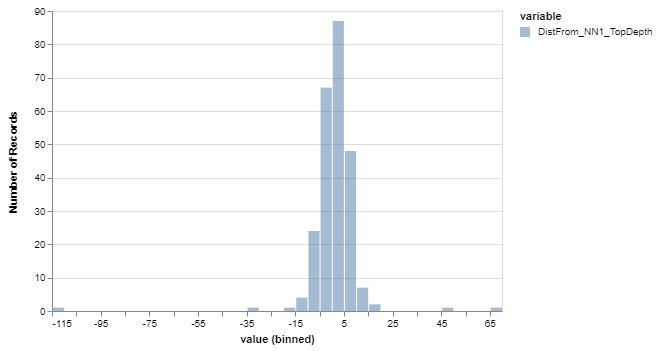

In [60]:
# 'MM_Top_Depth_predBy_NN1thick'
test_df_pred2_TopScratch2 = test_df_pred2[['DistFrom_NN1_TopDepth']]
test_df_pred2_TopScratch2.vgplot.hist(bins=75, alpha=0.5)

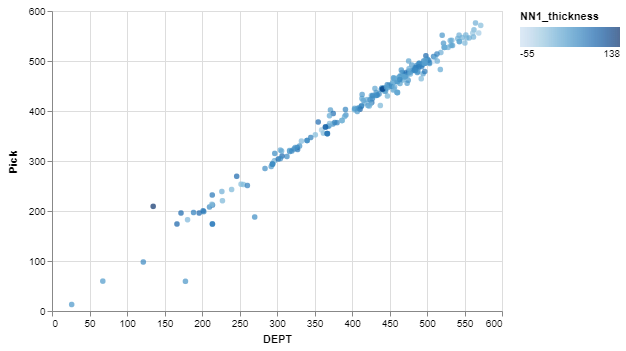

In [61]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='NN1_thickness')

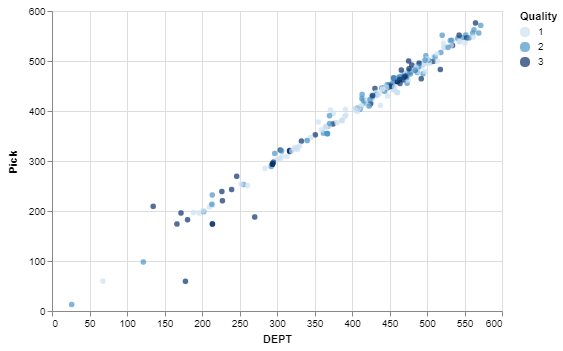

In [62]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='Quality')